In this notebook, I show how to fine-tune a NLLB-200 machine translation model for a new language.

The new language will be [Hittite](https://en.wikipedia.org/wiki/), and I will use a Hittite-English parallel corpus as the training data.

I am running this notebook on Google Colab with a T4 GPU that has 15Gb of memory. If you run it elsewhere, you may want to adjust the batch size, so that there are no OOM errors, but the GPU is well utilized.

# 0. Preliminaries

I run this notebook in Google Colab (which is ephemeral), and to read the dataset and to write the resulting model I use Google Drive, which I mount in the cell below.

In [1]:
# where I loaded in my train and test file paths
from google.colab import drive
import os
if not os.path.exists('/gd'):
    drive.mount('/content/drive')
    #dataset_file_path = "/content/drive/MyDrive/Hittite/HittiteDataset.json"
    dataset_file_path = "/content/drive/MyDrive/Colab Notebooks/NLLB_files/HittiteDataset.json"

Mounted at /content/drive


Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.6 MB/s eta 0:00:00


# 1. Exploring the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [4]:
import pandas as pd
import json

In [5]:
def json_to_pandas(path):
  dataset = []
  with open(dataset_file_path) as F:
    for l in F.readlines():
      l = json.loads(l)
      newL = dict()
      if l['Hittite']:
        newL['src_lang'] = l['Hittite']
        newL['tgt_lang'] = l['Translation']
      dataset.append(newL)

  df = pd.DataFrame.from_dict(dataset)
  return df


df = json_to_pandas(dataset_file_path)

print(df.shape)
print(df.columns)

(3144, 2)
Index(['src_lang', 'tgt_lang'], dtype='object')


In [6]:
pd.options.display.max_colwidth = 100

In [7]:
df.sample(10)

,src_lang,tgt_lang
2832,tekan / takn-,earth
2287,palḫi- / palḫai-,"wide, broad"
986,tissāi,to form.
650,nasma,or; − or if.
353,isharish,to fall ill with the Ishara sickness.
1012,tūwa,adv.
2784,tarḫuēšš-zi,to become powerful
1261,*arma-,moon(god); month
1509,*ḫaššuššara-,queen
1173,alwanzaḫḫ-i,to bewitch


In [8]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

df_train=df.sample(frac=0.9,random_state=200)
df_test=df.drop(df_train.index)

dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)

print(dataset_train)
print(dataset_test)

Dataset({
    features: ['src_lang', 'tgt_lang', '__index_level_0__'],
    num_rows: 2830
})
Dataset({
    features: ['src_lang', 'tgt_lang', '__index_level_0__'],
    num_rows: 314
})


# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(1000, random_state=1, replace='true')

smpl['eng_toks'] = smpl.tgt_lang.apply(tokenizer.tokenize)
smpl['hit_toks'] = smpl.src_lang.apply(tokenizer.tokenize)

smpl['eng_words'] = smpl.tgt_lang.apply(word_tokenize)
smpl['hit_words'] = smpl.src_lang.apply(word_tokenize)

In [13]:
smpl.sample(5)[['src_lang', 'hit_words', 'hit_toks', 'tgt_lang', 'eng_words', 'eng_toks']]

,src_lang,hit_words,hit_toks,tgt_lang,eng_words,eng_toks
912,dammesha,[dammesha],"[▁dam, mes, ha]",adv.,"[adv, .]","[▁adv, .]"
2354,parkuemar,[parkuemar],"[▁parku, emar]",purification(?),"[purification, (, ?, )]","[▁puri, fication, (, ?)]"
2510,šakuwāye/a-zi,"[šakuwāye, /, a, -, zi]","[▁š, akuw, ā, ye, /, a, -, zi]","to see, to look","[to, see, ,, to, look]","[▁to, ▁see, ,, ▁to, ▁look]"
1616,ḫuwapp-i / ḫupp-,"[ḫuwapp, -, i, /, ḫupp, -]","[▁, ḫ, uwa, pp, -, i, ▁/, ▁, ḫ, upp, -]","to be hostile towards, to do evil against (+ dat.-loc.)","[to, be, hostile, towards, ,, to, do, evil, against, (, +, dat, ., -, loc, ., )]","[▁to, ▁be, ▁hosti, le, ▁towards, ,, ▁to, ▁do, ▁evil, ▁against, ▁(+, ▁dat, .-, loc, .)]"
1241,araḫzanda,[araḫzanda],"[▁ara, ḫ, z, anda]",(all) around,"[(, all, ), around]","[▁(, all, ), ▁around]"


In [14]:
stats = smpl[['eng_toks', 'hit_toks', 'eng_words', 'hit_words']].applymap(len).describe()
stats

,eng_toks,hit_toks,eng_words,hit_words
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,6.294000,5.412000,5.454000,3.051000
std,6.509373,3.879601,6.279914,2.915287
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,2.000000,1.000000
50%,5.000000,4.500000,4.000000,2.000000
75%,8.000000,7.000000,7.000000,5.000000
max,117.000000,45.000000,121.000000,37.000000


In [15]:
print("eng tokens per word: ", stats.eng_toks['mean'] / stats.eng_words['mean'])
print("hit tokens per word: ", stats.hit_toks['mean'] / stats.hit_words['mean'])

eng tokens per word:  1.154015401540154
hit tokens per word:  1.7738446411012783


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


**How often does the <unk> token happen in the tokenizer output for Hittite? If this is too often, we need to fix it somehow**

In [17]:
texts_with_unk = [text for text in tqdm(df.src_lang) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print("Unique hit_tokens (<unk>): ", len(texts_with_unk))

  0%|          | 0/3144 [00:00<?, ?it/s]

Unique hit_tokens (<unk>):  564


In [18]:
# Show text samples that produce the unique token <unk>
# More than likely due to the unique character accents
import random
s = random.sample(texts_with_unk, 5)
s

['ḫuntariya(i)-tta(ri)',
 'išḫanittar',
 'ḫarnae-zi, ḫarniye/a-zi',
 'ḫurtāi- / ḫurti-',
 'ḫulḫuliye/a-zi']

*Apparently, most of the texts with unknown tokens just have some punctuation unfamiliar to the NLLB tokenizer.*

*This is because the NLLB model was pretrained on normalized texts. If we reproduce the normalization, most of the problems would be fixed.*

!!! Though this was true for the example that we adapted this colab from, it is not true for our Hittite implementation. As demonstrated below !!!

In [19]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [20]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print("Unique hit_tokens (<unk>): ", len(texts_with_unk_normed))

  0%|          | 0/564 [00:00<?, ?it/s]

Unique hit_tokens (<unk>):  549


After normalizing texts, we still see about the same number of unk tokens. Good evidence that we need to update the tokenizer vocabulary to use it with Hittite.

# 3 (optional). Expanding the vocabulary

# 4. Adding a new language tag to the tokenizer and model

In [21]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [22]:
#tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
tokenizer = NllbTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/NLLB_files/saved_model')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256203, 256203]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


256205
['<mask>', '<mask>']


In [23]:
def fix_tokenizer(tokenizer, new_lang='hit_Tite'): # <-- hittite
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [24]:
fix_tokenizer(tokenizer)

In [25]:
print(tokenizer.convert_ids_to_tokens([256047, 256203, 256204])) # ['eng_Latn', 'hit_Tite', '<mask>']
print(tokenizer.convert_tokens_to_ids(['hit_Tite', 'eng_Latn', '<mask>'])) # [256203, 256047, 256204]
# this is consistent now, wow!

['eng_Latn', 'hit_Tite', '<mask>']
[256203, 256047, 256204]


**This is where we initialize the new language tag for the model**

In [26]:
# fixing the new/moved token embeddings in the model
added_token_id = tokenizer.convert_tokens_to_ids('hit_Tite')
similar_lang_id = tokenizer.convert_tokens_to_ids('tur_Latn') # <-- needs research!!!
print(added_token_id, similar_lang_id)

256203 256184


In [27]:
#model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model = AutoModelForSeq2SeqLM.from_pretrained('/content/drive/MyDrive/Colab Notebooks/NLLB_files/saved_model')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024, padding_idx=1)

In [28]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# 5. Preparing the training loop

In [29]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [30]:
model.cuda();

In [31]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [32]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=1_000)

In [33]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 10000

In [34]:
LANGS = [('src_lang', 'hit_Tite'), ('tgt_lang', 'eng_Latn')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = df_train.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['to make inauspicious'], ['kallaraḫḫ-i'], 'eng_Latn', 'hit_Tite')


In [ ]:
#MODEL_SAVE_PATH = '/content/drive/MyDrive/Hittite'
MODEL_SAVE_PATH = '/content/drive/MyDrive/Colab Notebooks/NLLB_files/saved_model'

# 6. The training loop

In [ ]:

x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)


  0%|          | 0/10000 [00:00<?, ?it/s]

0 1.7756584882736206
1000 0.09678989576354434
2000 0.028381983369607268
3000 0.028367137739647434


**Load saved model**

In [35]:
#tokenizer = NllbTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/NLLB_files/saved_model2')
#model = AutoModelForSeq2SeqLM.from_pretrained('/content/drive/MyDrive/Colab Notebooks/NLLB_files/saved_model2')

In [36]:
'''
def fix_tokenizer(tokenizer, new_lang='hit_Tite'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}
    '''

'\ndef fix_tokenizer(tokenizer, new_lang=\'hit_Tite\'):\n    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """\n    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)\n    tokenizer.lang_code_to_id[new_lang] = old_len-1\n    tokenizer.id_to_lang_code[old_len-1] = new_lang\n    # always move "mask" to the last position\n    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset\n\n    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)\n    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}\n    if new_lang not in tokenizer._additional_special_tokens:\n        tokenizer._additional_special_tokens.append(new_lang)\n    # clear the added token encoder; otherwise a new token may end up there by mistake\n    tokenizer.added_tokens_encoder = {}\n    tokenizer.added_tokens_de

In [37]:
#fix_tokenizer(tokenizer)

<ipython-input-38-170bb04377cf>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(losses).ewm(100).mean().plot();


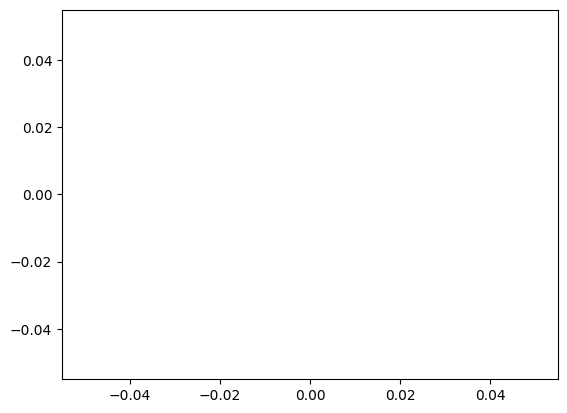

In [38]:
pd.Series(losses).ewm(100).mean().plot();

In [39]:
'''
def translate(text, src_lang='hit_Tite', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)
    '''

"\ndef translate(text, src_lang='hit_Tite', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):\n    tokenizer.src_lang = src_lang\n    tokenizer.tgt_lang = tgt_lang\n    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)\n    result = model.generate(\n        **inputs.to(model.device),\n        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),\n        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),\n        **kwargs\n    )\n    #print(inputs.input_ids.shape[1], result.shape[1])\n    return tokenizer.batch_decode(result, skip_special_tokens=True)\n    "

In [40]:
'''
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_test)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))
'''

'\nxx, yy, lang1, lang2 = get_batch_pairs(1, data=df_test)\nprint(xx)\nprint(yy)\nmodel.eval()\nprint(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))\n'

In [41]:
#!ls -alsh $MODEL_SAVE_PATH

# 7. Using the model

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [43]:
'''
trans_df = pd.read_csv('/gd/MyDrive/datasets/nlp/tyvan/for_translator.csv')
trans_df.dropna(subset=['ru', 'tyv'], inplace=True)
df_train, df_devtest = train_test_split(trans_df, test_size=1000, random_state=1)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=1)
'''

"\ntrans_df = pd.read_csv('/gd/MyDrive/datasets/nlp/tyvan/for_translator.csv')\ntrans_df.dropna(subset=['ru', 'tyv'], inplace=True)\ndf_train, df_devtest = train_test_split(trans_df, test_size=1000, random_state=1)\ndf_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=1)\n"

In [44]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [45]:
def fix_tokenizer(tokenizer, new_lang='hit_Tite'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [46]:
model_load_name = '/content/drive/MyDrive/Colab Notebooks/NLLB_files/saved_model'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [47]:
def translate(text, src_lang='hit_Tite', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [48]:
t = "wet"
print(translate(t, 'eng_Latn', 'hit_Tite'))
t = "atis"
print(translate(t, 'hit_Tite', 'eng_Latn'))

['apae-']
['axe.']


In [49]:
translate(t, 'hit_Tite', 'eng_Latn', do_sample=True, num_beams=1, temperature=1.5)

['axe.']

In [50]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [51]:
hit_translated = batched_translate(df_test.src_lang, src_lang='hit_Tite', tgt_lang='eng_Latn')

  0%|          | 0/20 [00:00<?, ?it/s]

**Metrics**

In [52]:
df_test['hit_translated'] = [translate(t, 'hit_Tite', 'eng_Latn')[0] for t in tqdm(df_test.src_lang)]
df_test['eng_translated'] = [translate(t, 'eng_Latn', 'hit_Tite')[0] for t in tqdm(df_test.tgt_lang)]

  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

In [53]:
import sacrebleu
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [54]:
xx, yy = ['allaniya'], ['to sweat.']
print(chrf_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(yy, [xx]))

chrF2++ = 1.79
chrF2++ = 1.79


In [55]:
print(chrf_calc.corpus_score(df_test['hit_translated'].tolist(), [df_test['tgt_lang'].tolist()])) # (test value, true value)
print(chrf_calc.corpus_score(df_test['eng_translated'].tolist(), [df_test['src_lang'].tolist()])) # (test value, true value)

chrF2++ = 15.63
chrF2++ = 16.86


In [56]:
pd.options.display.max_colwidth = 100

In [57]:
df_test.sample(10, random_state=5)[['src_lang', 'tgt_lang', 'eng_translated', 'hit_translated']]

output = df_test.sample(300, random_state=5)[['src_lang', 'tgt_lang', 'eng_translated', 'hit_translated']]

File export

In [58]:
! pip install xlwt openpyxl xlsxwriter xlrd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.0 MB/s eta 0:00:00


In [59]:
from google.colab import files
df_test.to_csv('filename.csv')
files.download('filename.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
print((df_test.tgt_lang == df_test.hit_translated).mean())
print((df_dev.src_lang == df_dev.eng_translated).mean())

0.03821656050955414


NameError: ignored